In [1]:
%load_ext autoreload
%autoreload 2
from project_transformer import Data_Wrangling

In [2]:
import pandas as pd
import numpy as np
from underthesea import word_tokenize, pos_tag, sent_tokenize, sentiment
import re
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import os 
from tqdm.auto import tqdm

In [3]:
tqdm.pandas()
pd.option_context('mode.use_inf_as_na', True)

In [4]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def extract_adjectives_vietnamese(comment):
    # Perform part-of-speech tagging
    tagged_words = pos_tag(comment)

    # Extract adjectives
    adjectives = [word for word, pos in tagged_words if pos == 'A']

    return adjectives

In [6]:
def get_top_duplicated_words(word_list, top_n=5):
    word_count_dict = Counter(word_list)

    # Get the top N duplicated words
    top_duplicated_words = word_count_dict.most_common(top_n)

    return top_duplicated_words

In [7]:
def create_word_count_dictionary(word_list):
    word_count_dict = defaultdict(int)

    # Count the occurrences of each word
    for word in word_list:
        word_count_dict[word] += 1

    # Convert the defaultdict to a regular dictionary
    word_count_dict = dict(word_count_dict)

    return word_count_dict

# Load Some Data to preprocess Vietnamese languages

In [8]:
# EMOJI
with open('../DATA/files/emojicon.txt', 'r', encoding="utf8") as file:
    emoji_lst = file.read().split('\n')
    emoji_dict = {}
    for line in emoji_lst:
        key, value = line.split('\t')
        emoji_dict[key] = str(value)

# TEEN CODE
with open('../DATA/files/teencode.txt', 'r', encoding="utf8") as file:
    teen_lst = file.read().split('\n')
    teen_dict = {}
    for line in teen_lst:
        key, value = line.split('\t')
        teen_dict[key] = str(value)

# ENG VIET
with open('../DATA/files/english-vnmese.txt', 'r', encoding="utf8") as file:
    eng_lst = file.read().split('\n')
    eng_dict = {}
    for line in eng_lst:
        key, value = line.split('\t')
        eng_dict[key] = str(value)

# WRONG WORD
with open('../DATA/files/wrong-word.txt', 'r', encoding="utf8") as file:
    wrong_lst = file.read().split('\n')

# STOP WORD
with open('../DATA/files/vietnamese-stopwords.txt', 'r', encoding="utf8") as file:
    stop_lst = file.read().split('\n')

## Build CLEANSER

In [9]:
data_cleanser = Data_Wrangling(emoji_dict=emoji_dict,
                               teen_dict=teen_dict,
                               wrong_lst=wrong_lst,
                               eng_vn_dict=eng_dict,
                               stop_words=stop_lst)

In [10]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [11]:
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "ngonnnn" thành "ngon", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

In [12]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [13]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = (' '.join( word[0] if word[1].upper() in lst_word_type else '' 
                             for word in pos_tag(process_special_word(
                                 word_tokenize(sentence, format="text")
                             )
                                                )
                            )
                   )
        new_document = new_document + sentence + ' '
        
    # DEL excess blank space
    new_document = re.sub(r'\s+', ' ', new_document).strip()

    # Remove duplicated characters
    new_document = normalize_repeated_characters(text=new_document)

    # Remove stop words
    # new_document = remove_stopword(text=new_document,stopwords=stop_lst)
    return new_document

# Overview Data

## Rating details 

In [14]:
rating_details = pd.read_csv('../DATA/cung_cap_HV/Products_ThoiTrangNam_rating_raw.csv',delimiter='\t')
print(rating_details.info())
rating_details.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024482 entries, 0 to 1024481
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   product_id  1024482 non-null  int64 
 1   user_id     1024482 non-null  int64 
 2   user        1024482 non-null  object
 3   rating      1024482 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 31.3+ MB
None


,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


## Description of Products

In [15]:
prd_des_df = pd.read_csv('../DATA/cung_cap_HV/Products_ThoiTrangNam_raw.csv')
print(prd_des_df.info())
prd_des_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49663 entries, 0 to 49662
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49663 non-null  int64  
 1   product_name  49663 non-null  object 
 2   category      49663 non-null  object 
 3   sub_category  49663 non-null  object 
 4   link          49663 non-null  object 
 5   image         36443 non-null  object 
 6   price         49663 non-null  float64
 7   rating        49663 non-null  float64
 8   description   48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB
None


,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


# EDA:

## Rating Details

In [22]:
print("Shape of rating details:",rating_details.shape)
rating_details.head()

Shape of rating details: (1024482, 4)


,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


In [17]:
rating_details.isna().sum()

product_id    0
user_id       0
user          0
rating        0
dtype: int64

- Remove nan and transform to datetime

In [18]:
clean_details_df = rating_details.drop(columns='user')
clean_details_df.head()

,product_id,user_id,rating
0,190,1,5
1,190,2,5
2,190,3,5
3,190,4,5
4,190,5,5


- Check unique values and transform to ID

In [19]:
clean_details_df.nunique()

product_id     31267
user_id       650636
rating             5
dtype: int64

### Numeric data

In [20]:
clean_details_df['rating'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

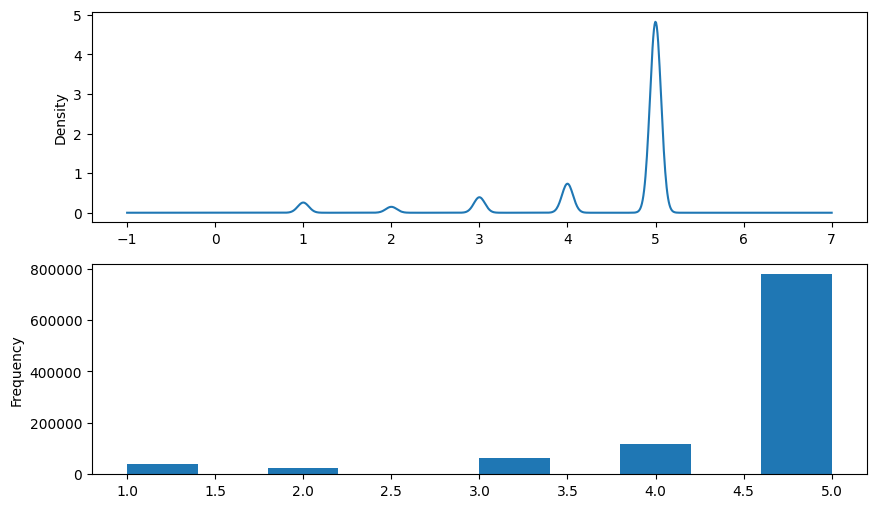

In [21]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
clean_details_df['rating'].plot(kind='kde',ax=ax[0])
clean_details_df['rating'].plot(kind='hist',ax=ax[1])
plt.show()

- Drop some data 

#### Drop some product with low rating and drop user with one time buy

##### PRD

In [23]:
clean_details_df.head()

,product_id,user_id,rating
0,190,1,5
1,190,2,5
2,190,3,5
3,190,4,5
4,190,5,5


In [39]:
group_prd = (clean_details_df.groupby('product_id',as_index=False)
              .agg({'user_id':'count', 'rating':'mean'})
              .rename(columns={'user_id':'count_user','rating':'avg_rate'}))
group_prd.head()

,product_id,count_user,avg_rate
0,100,134,4.328358
1,101,97,4.793814
2,102,132,4.371212
3,103,135,4.385185
4,104,95,4.778947


In [52]:
filter_1 = group_prd['avg_rate'] >=3
group_prd_gt_3 = group_prd[filter_1]
group_prd_gt_3.head()

,product_id,count_user,avg_rate
0,100,134,4.328358
1,101,97,4.793814
2,102,132,4.371212
3,103,135,4.385185
4,104,95,4.778947


In [53]:
list_prd = group_prd_gt_3['product_id'].to_list()
print('Total product:',len(list_prd))
list_prd[:5]

Total product: 30961


[100, 101, 102, 103, 104]

##### User Group

In [42]:
group_user = (clean_details_df.groupby('user_id',as_index=False)
              .agg({'product_id':'count', 'rating':'mean'})
              .rename(columns={'product_id':'count_prd','rating':'avg_rate'}))
group_user.head()

,user_id,count_prd,avg_rate
0,1,1,5.0
1,2,2,5.0
2,3,1,5.0
3,4,1,5.0
4,5,5,5.0


In [45]:
filter_2 = group_user['count_prd'] >= 2
group_user_gt_2 = group_user[filter_2]
print('Total customer:', group_user_gt_2.shape)
group_user_gt_2.head(5)

Total customer: (113654, 3)


,user_id,count_prd,avg_rate
1,2,2,5.000000
4,5,5,5.000000
5,6,5,5.000000
7,8,59,4.372881
8,9,3,4.333333


In [46]:
list_user = group_user_gt_2['user_id'].to_list()
print("Total user:",len(list_user))
list_user[:5]

Total user: 113654


[2, 5, 6, 8, 9]

In [56]:
filter_11 = clean_details_df['product_id'].isin(list_prd)
final_detail_df = clean_details_df[filter_11]
print("Shape final_df:",final_detail_df.shape)
final_detail_df.head()

Shape final_df: (1022489, 3)


,product_id,user_id,rating
0,190,1,5
1,190,2,5
2,190,3,5
3,190,4,5
4,190,5,5


In [57]:
filter_22 = final_detail_df['user_id'].isin(list_user)
final_detail_df = final_detail_df[filter_22]
print("Shape final_df:",final_detail_df.shape)
final_detail_df.head()

Shape final_df: (486351, 3)


,product_id,user_id,rating
1,190,2,5
4,190,5,5
5,190,6,5
7,190,8,5
8,190,9,5


### Save Data:

In [59]:
final_detail_df.describe()

,product_id,user_id,rating
count,486351.000000,486351.000000,486351.000000
mean,62408.151668,143226.680073,4.567095
std,83086.216321,173845.983819,0.974977
min,100.000000,2.000000,1.000000
25%,13455.000000,1305.000000,5.000000
50%,18938.000000,57304.000000,5.000000
75%,131012.000000,245489.000000,5.000000
max,261469.000000,650003.000000,5.000000


In [58]:
final_detail_df.to_csv('../DATA/clean_details.csv',index=False)

## Description Data

In [23]:
print(prd_des_df.shape)
prd_des_df.head()

(49663, 9)


,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [24]:
prd_des_df.isna().sum()

product_id          0
product_name        0
category            0
sub_category        0
link                0
image           13220
price               0
rating              0
description       963
dtype: int64

In [25]:
prd_des_df.nunique()

product_id      49653
product_name    47103
category            1
sub_category       17
link            49653
image           35191
price            7792
rating             31
description     45071
dtype: int64

In [26]:
clean_prd_df = prd_des_df.drop(columns=['category','link','image'])

- Check na values

In [27]:
clean_prd_df[clean_prd_df['description'] == '\n\n']

,product_id,product_name,sub_category,price,rating,description
69,1969,Áo ba lỗ Gym Shark nam sát nách dập vân thun l...,Áo Ba Lỗ,55000.0,5.0,\n\n
119,19119,ÁO BA LỖ NAM CAO CẤP COTTON 100% THẤM HÚT MỒ H...,Áo Ba Lỗ,99000.0,4.9,\n\n
142,19142,Áo Tanktop sát nách ba lỗ cho nam dáng thể tha...,Áo Ba Lỗ,55000.0,5.0,\n\n
180,19180,Áo ba lỗ nam -Áo tank top tập gym nam cao cấp ...,Áo Ba Lỗ,48500.0,4.9,\n\n
183,19183,Áo Tank Top Nam 💝Giống Hình 100%💝 Áo Thun 3 Lỗ...,Áo Ba Lỗ,69000.0,5.0,\n\n
...,...,...,...,...,...,...
49411,174816,Tất Vớ cổ cao thể thao Nam kẻ 3 sọc chính hãng...,Vớ/Tất,45000.0,5.0,\n\n
49416,174821,CB106 Combo 10 đôi tất vớ nam kiểu 6,Vớ/Tất,49900.0,5.0,\n\n
49428,174833,Đôi tất thể thao dài qua gối thoáng khí thoải ...,Vớ/Tất,35000.0,4.7,\n\n
49583,174988,10 đôi tất lưới Nam thông hơi chống hôi chân,Vớ/Tất,97000.0,5.0,\n\n


In [28]:
drop_index = clean_prd_df[clean_prd_df.duplicated(subset=['product_id'],keep=False)&(clean_prd_df['description'] == '\n\n')].index
clean_prd_df = clean_prd_df.drop(index=drop_index)

- View duplicate

In [29]:
clean_prd_df[clean_prd_df.duplicated(subset=['product_id'],keep=False)].sort_values('product_id')

,product_id,product_name,sub_category,price,rating,description
25401,11824,Quần baggy ống rộng khoá gối - Hot 2021 - Jean...,Khác,165220.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
30437,11824,Quần baggy ống rộng khoá gối - Hot 2021 - Jean...,Khác,165220.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
25406,11829,Mũ Lưỡi Trai Cotton Thêu Chữ Ground Thời Trang...,Khác,54000.0,4.7,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
30439,11829,Mũ Lưỡi Trai Cotton Thêu Chữ Ground Thời Trang...,Khác,52000.0,4.7,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
25419,11842,Xích quần Jeans - Mã XQJ043,Khác,159000.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
30442,11842,Xích quần Jeans - Mã XQJ043,Khác,159000.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
25434,11857,Thắt lưng vải canvas chất lượng cao thời trang...,Khác,26100.0,4.5,Danh Mục\nShopee\nThời Trang Nam\nKhác\nSố lượ...
30445,11857,Thắt lưng vải canvas chất lượng cao thời trang...,Khác,26100.0,4.5,Danh Mục\nShopee\nThời Trang Nam\nKhác\nSố lượ...
25437,11860,Vòng Tay và Nhẫn Unisex Tin Dành Cho Nam Nữ Th...,Khác,44000.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...
30446,11860,Vòng Tay và Nhẫn Unisex Tin Dành Cho Nam Nữ Th...,Khác,44000.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nKhác\nKho hà...


In [30]:
clean_prd_df = clean_prd_df.drop_duplicates(subset='product_id')

In [31]:
#clean_prd_df[clean_prd_df.duplicated(subset=['product_name'],keep=False)].sort_values('product_name')

In [32]:
clean_prd_df.head()

,product_id,product_name,sub_category,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Áo Ba Lỗ,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Áo Ba Lỗ,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Áo Ba Lỗ,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Áo Ba Lỗ,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Ba Lỗ,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


### Clean Description:

In [39]:
descriptions = clean_prd_df['description'].str.split(pat='\n').to_list()

In [96]:
len(descriptions)

49653

In [117]:
#full_des[100]

In [93]:
full_des = []
for des in tqdm(descriptions,'Pre-process Description'):
    if isinstance(des,list):
        new_ls = []
        for words in des:
            if (words not in stop_lst)  and (words != '') and (not words.isnumeric()):
                new_words = data_cleanser.process_text(text=words)
                new_words 
                if new_words != '':
                    new_ls.append(new_words)
    
        # Process pos_tag
        prd_des_str = ' '.join(new_ls)
        prd_des_thesea = data_cleanser.process_postag_thesea(prd_des_str)
    
        # Append to list 
        full_des.append(prd_des_thesea)
    else:
        full_des.append(des)

Pre-process Description:   0%|          | 0/49653 [00:00<?, ?it/s]

In [94]:
len(full_des)

49653

In [98]:
clean_prd_df['clean_desc'] = full_des

In [102]:
clean_prd_df = clean_prd_df.drop(columns=['description'])

In [103]:
clean_prd_df.head()

,product_id,product_name,sub_category,price,rating,clean_desc
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Áo Ba Lỗ,86250.0,4.9,áo lỗ chiều đường_phố nhiệt_đới tal fit xuất_x...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Áo Ba Lỗ,26800.0,4.9,áo lỗ xuất_xứ việt_nam tổ_chức trách_nhiệm sản...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Áo Ba Lỗ,39500.0,4.8,áo lỗ thương_hiệu tyasuo chiều áo không_thể đư...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Áo Ba Lỗ,16500.0,4.8,áo lỗ chất_liệu hàng gửi hà_nội áo lỗ nam mặc ...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Ba Lỗ,45000.0,4.8,áo lỗ chiều áo không_thể hàng gửi hà_nội thông...


#### Clean Product Name:

In [126]:
clean_prd_name =  clean_prd_df['product_name'].progress_apply(lambda x: data_cleanser.process_text(x))

  0%|          | 0/49653 [00:00<?, ?it/s]

In [127]:
clean_prd_name

0                     áo ba lỗ thun gân form body tôn dáng
1         áo ba lỗ nam trắng chất cotton siêu mát siêu đẹp
2        áo ba lỗ nam tyasuo chất vải co dãn mát không ...
3                            áo ba lỗ hàng việt nam cotton
4              áo thun nam thể thao ba lỗ mẫu mới siêu đẹp
                               ...                        
49658    tất vớ nam cổ cao cao cấp tất vớ đi giày công ...
49659    tất nam livan sport chất liệu bamboo kháng khu...
49660     combo đôi tất vớ hài chống hôi chân uni hàng xịn
49661                       hộp đôi tất chống hôi chân nam
49662          combo đôi tất nam nữ cao cấp không hôi chân
Name: product_name, Length: 49653, dtype: object

In [128]:
clean_prd_name = clean_prd_name.progress_apply(lambda x: data_cleanser.process_postag_thesea(x))

  0%|          | 0/49653 [00:00<?, ?it/s]

In [130]:
clean_prd_df['clean_prd_name'] = clean_prd_name

In [131]:
clean_prd_df.to_csv(path_or_buf='../DATA/clean_products.csv',index=True)

In [132]:
clean_prd_df.head()

,product_id,product_name,sub_category,price,rating,clean_desc,clean_prd_name
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Áo Ba Lỗ,86250.0,4.9,áo lỗ chiều đường_phố nhiệt_đới tal fit xuất_x...,áo lỗ thun gân form body
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Áo Ba Lỗ,26800.0,4.9,áo lỗ xuất_xứ việt_nam tổ_chức trách_nhiệm sản...,áo lỗ nam trắng chất_cotton siêu_mát đẹp
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Áo Ba Lỗ,39500.0,4.8,áo lỗ thương_hiệu tyasuo chiều áo không_thể đư...,áo lỗ nam tyasuo chất vải co_dãn mát không_xù mềm
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Áo Ba Lỗ,16500.0,4.8,áo lỗ chất_liệu hàng gửi hà_nội áo lỗ nam mặc ...,áo lỗ hàng việt_nam
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Ba Lỗ,45000.0,4.8,áo lỗ chiều áo không_thể hàng gửi hà_nội thông...,áo thun nam thể_thao lỗ mẫu mới đẹp


# EDA DEEPER:

In [61]:
clean_prd_df = pd.read_csv('../DATA/clean_products.csv')
clean_prd_df.head()

,Unnamed: 0,product_id,product_name,sub_category,price,rating,clean_desc,clean_prd_name
0,0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Áo Ba Lỗ,86250.0,4.9,áo lỗ chiều đường_phố nhiệt_đới tal fit xuất_x...,áo lỗ thun gân form body
1,1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Áo Ba Lỗ,26800.0,4.9,áo lỗ xuất_xứ việt_nam tổ_chức trách_nhiệm sản...,áo lỗ nam trắng chất_cotton siêu_mát đẹp
2,2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Áo Ba Lỗ,39500.0,4.8,áo lỗ thương_hiệu tyasuo chiều áo không_thể đư...,áo lỗ nam tyasuo chất vải co_dãn mát không_xù mềm
3,3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Áo Ba Lỗ,16500.0,4.8,áo lỗ chất_liệu hàng gửi hà_nội áo lỗ nam mặc ...,áo lỗ hàng việt_nam
4,4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Ba Lỗ,45000.0,4.8,áo lỗ chiều áo không_thể hàng gửi hà_nội thông...,áo thun nam thể_thao lỗ mẫu mới đẹp


In [62]:
clean_prd_df.describe()

,Unnamed: 0,product_id,price,rating
count,49653.000000,49653.000000,4.965300e+04,49653.000000
mean,24830.274646,117102.960647,2.337032e+05,3.085137
std,14337.927559,83780.341243,9.854160e+05,2.339682
min,0.000000,100.000000,0.000000e+00,0.000000
25%,12413.000000,21913.000000,6.900000e+04,0.000000
50%,24826.000000,114911.000000,1.419000e+05,4.800000
75%,37249.000000,174078.000000,2.686420e+05,5.000000
max,49662.000000,261499.000000,1.000000e+08,5.000000
